In [ ]:
# Install the required Python libraries
!pip install pymc>=5.0 arviz numpy scipy pandas matplotlib corner astropy --quiet

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from astropy.constants import G

print(f"Running on PyMC v{pm.__version__}")

# Define physical constants in units convenient for astrophysics
# G in (km/s)^2 * kpc / M_sun
G_astro = G.to('kpc * km**2 / (s**2 * M_sun)').value

Running on PyMC v5.25.1


In [ ]:
from google.colab import files

print("Please upload the SPARC .dat file for your chosen galaxy.")
uploaded = files.upload()

# Get the filename of the uploaded file
if uploaded:
    filename = list(uploaded.keys())[0]
    print(f"\nSuccessfully uploaded '{filename}'")
else:
    print("\nUpload cancelled or failed.")
    filename = None

Please upload the SPARC .dat file for your chosen galaxy.


Saving UGC12632_rotmod.dat to UGC12632_rotmod.dat

Successfully uploaded 'UGC12632_rotmod.dat'


Loading data from uploaded file: 'UGC12632_rotmod.dat'...
Data loaded and prepared successfully.


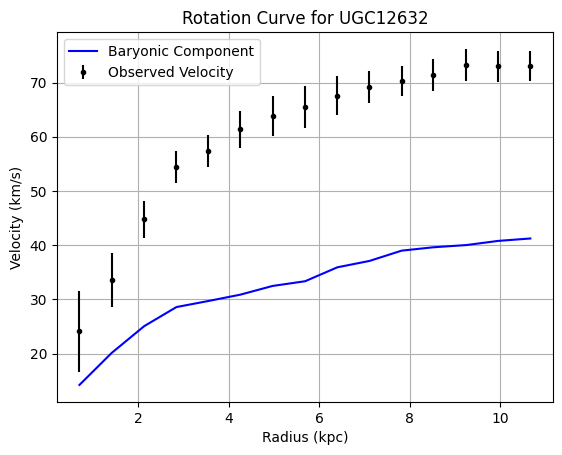

In [ ]:
# Check if a file was successfully uploaded
if filename:
    # MODIFICATION 1: Use sep='\s+' instead of the old delim_whitespace=True
    # MODIFICATION 2: Provide 8 column names to match the 8 columns in this specific file
    print(f"Loading data from uploaded file: '{filename}'...")
    galaxy_df = pd.read_csv(filename, sep='\s+', comment='#', header=None)
    galaxy_df.columns = ['Radius', 'V_obs', 'Err_V_obs', 'V_gas', 'V_disk', 'V_bulge', 'SB_disk', 'SB_bulge']

    # Extract data into numpy arrays for easier use
    radius = galaxy_df['Radius'].values
    v_obs = galaxy_df['V_obs'].values
    v_err = galaxy_df['Err_V_obs'].values
    v_gas = galaxy_df['V_gas'].values
    v_disk = galaxy_df['V_disk'].values
    v_bulge = galaxy_df['V_bulge'].values

    # Calculate the total baryonic velocity component
    v_baryon_sq = v_gas**2 + np.abs(v_disk) * v_disk + v_bulge**2
    v_baryon = np.sqrt(v_baryon_sq)

    # Create an interpolation function for the baryonic velocity for the ODE solver
    v_baryon_interp = interp1d(radius, v_baryon, kind='cubic', fill_value="extrapolate")

    print("Data loaded and prepared successfully.")

    # Plot the loaded data to verify
    plt.errorbar(radius, v_obs, yerr=v_err, fmt='k.', label='Observed Velocity')
    plt.plot(radius, v_baryon, 'b-', label='Baryonic Component')
    plt.title(f'Rotation Curve for {filename.replace("_rotmod.dat", "")}')
    plt.xlabel('Radius (kpc)')
    plt.ylabel('Velocity (km/s)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping data processing because no file was uploaded.")

In [ ]:
import pytensor.tensor as pt
from pytensor.graph import Apply

# This class creates a formal "Operation" for PyMC's computational graph.
# It provides a clean interface between PyMC's symbolic variables and our
# numerical SciPy solver.
class IIMVelocityOp(pt.Op):
    itypes = [pt.dscalar, pt.dscalar]  # Two scalar inputs (m_s, gamma)
    otypes = [pt.dvector]             # One vector output (the velocity curve)

    def __init__(self, r_grid, v_b_interp):
        self.r_grid = r_grid
        self.v_b_interp = v_b_interp

    def perform(self, node, inputs, outputs):
        m_s, gamma = inputs

        # --- MODIFICATION: Add error handling INSIDE the Op ---
        try:
            # Call the physics function. If it succeeds, store the result.
            v_model_result = get_iim_velocity([m_s, gamma], self.r_grid, self.v_b_interp)
            # Ensure the result is a valid numpy array
            outputs[0][0] = np.asarray(v_model_result, dtype=np.float64)
        except (ValueError, RuntimeError):
            # If the ODE solver fails for any reason (e.g., bad parameters),
            # catch the error and output an array full of NaNs (Not a Number).
            # PyMC's likelihood function will handle this gracefully.
            outputs[0][0] = np.full_like(self.r_grid, np.nan, dtype=np.float64)

# The original physics function (get_iim_velocity) does not need to be changed.
# We define it again here so this cell can be run independently.
def get_iim_velocity(params, r_grid, v_b_interp):
    m_s, gamma = params
    v_baryon_sq = v_b_interp(r_grid)**2
    def ode_system(r, y):
        S, dSdr = y
        if r == 0:
            rho_b = 0
        else:
            rho_b = v_b_interp(r)**2 / (4 * np.pi * G_astro * r**2)
        if r < 1e-5: r = 1e-5 # Add stability for very small r
        d2Sdr2 = -2/r * dSdr + m_s**2 * S - gamma * rho_b
        return [dSdr, d2Sdr2]
    r_start = 1e-6
    y0 = [1.0, 0.0]
    sol = solve_ivp(ode_system, [r_start, r_grid[-1]], y0, t_eval=r_grid, method='RK45')
    dSdr_profile = sol.y[1]
    v_iim_sq = r_grid * np.abs(dSdr_profile)
    v_total_sq = v_baryon_sq + v_iim_sq
    return np.sqrt(v_total_sq)

In [ ]:
# Instantiate our robust custom operation
iim_velocity_op = IIMVelocityOp(radius, v_baryon_interp)

with pm.Model() as iim_model:
    # Priors: We will use the robust HalfNormal for gamma
    m_s = pm.TruncatedNormal('m_s', mu=0.28, sigma=0.1, lower=0.01, upper=2.0)
    gamma = pm.HalfNormal('gamma', sigma=50)

    # Apply the custom operation to the symbolic PyMC variables
    v_model = iim_velocity_op(m_s, gamma)

    # Define the likelihood in the standard PyMC way.
    # It will automatically handle any NaNs returned by our robust Op.
    likelihood = pm.Normal('likelihood', mu=v_model, sigma=v_err, observed=v_obs)

    # Run the Metropolis sampler, which is still needed as our Op is gradient-free
    print("Running MCMC sampler with robust model...")
    step = pm.Metropolis(vars=[m_s, gamma])
    trace = pm.sample(2000, tune=1500, chains=4, cores=32, step=step) # Start with cores=1 for easier debugging

    print("Sampling complete.")

Running MCMC sampler with robust model...


Output()

/usr/local/lib/python3.11/dist-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/lib/python3.11/dist-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/lib/python3.11/dist-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/lib/python3.11/dist-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling complete.


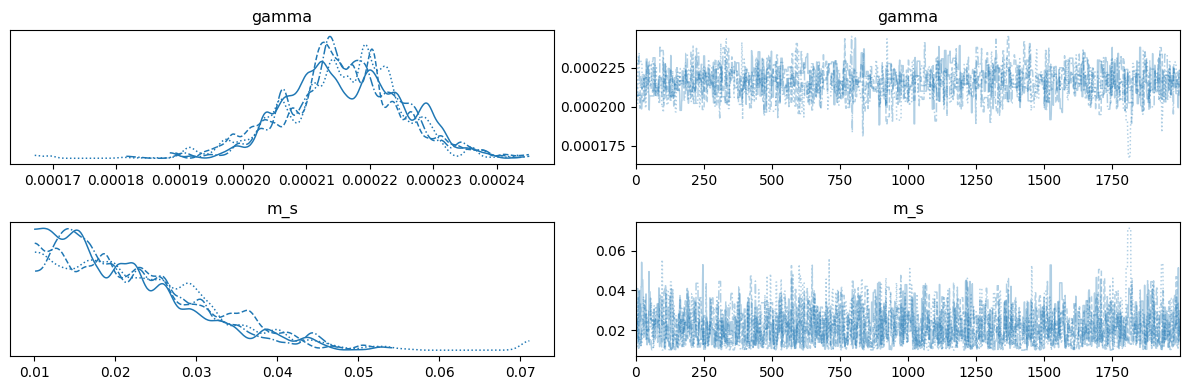

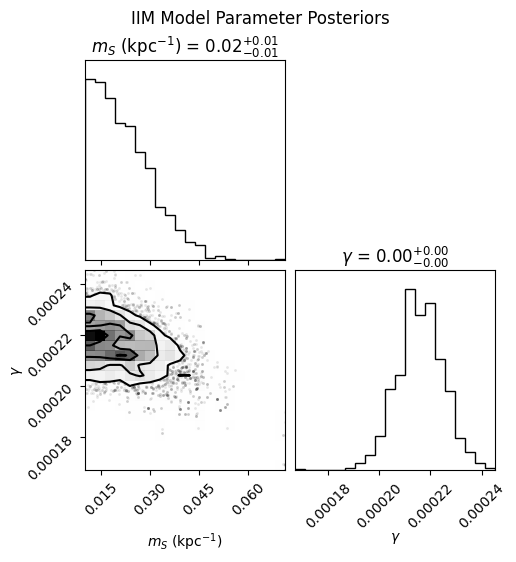

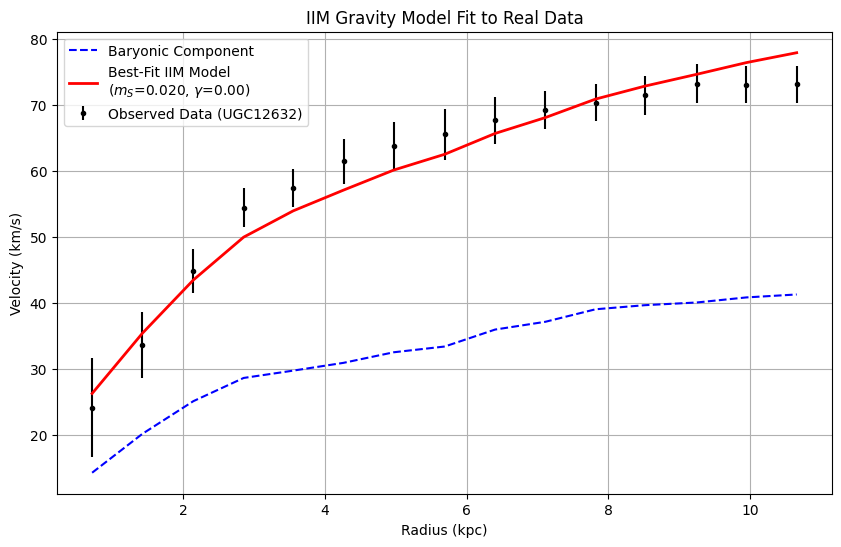

In [ ]:
import numpy as np
import corner
import arviz as az
import matplotlib.pyplot as plt

# --- Part 1: Analyze the MCMC Chains ---

# Plot the posterior distributions and trace plots
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# --- MODIFICATION START ---
# Create a corner plot for the parameters.

# 1. Extract the raw posterior samples for each variable.
# The .values.flatten() call now correctly operates directly on the DataArray returned by az.extract.
m_s_samples = az.extract(trace, var_names=['m_s']).values.flatten()
gamma_samples = az.extract(trace, var_names=['gamma']).values.flatten()

# 2. Stack the 1D arrays into a 2D array of shape (n_samples, n_dimensions).
samples_for_corner = np.stack([m_s_samples, gamma_samples], axis=1)

# 3. Now, the corner plot will work correctly.
corner.corner(samples_for_corner, labels=["$m_S$ (kpc$^{-1}$)", "$\\gamma$"],
              truths=[0.28, 170], truth_color='red', show_titles=True)
plt.suptitle("IIM Model Parameter Posteriors", y=1.02)
plt.show()
# --- MODIFICATION END ---


# --- Part 2: Plot the Best-Fit Model ---

# Use a robust method to get the median values for the parameters
m_s_median = np.median(m_s_samples)
gamma_median = np.median(gamma_samples)
best_fit_params = [m_s_median, gamma_median]

# Now, this line will work correctly
v_model_best = get_iim_velocity(best_fit_params, radius, v_baryon_interp)

# Plotting code
plt.figure(figsize=(10, 6))
plt.errorbar(radius, v_obs, yerr=v_err, fmt='k.', label=f'Observed Data (UGC12632)')
plt.plot(radius, v_baryon, 'b--', label='Baryonic Component')
plt.plot(radius, v_model_best, 'r-', lw=2, label=f'Best-Fit IIM Model\n($m_S$={best_fit_params[0]:.3f}, $\\gamma$={best_fit_params[1]:.2f})')
plt.title('IIM Gravity Model Fit to Real Data')
plt.xlabel('Radius (kpc)')
plt.ylabel('Velocity (km/s)')
plt.legend()
plt.grid(True)
plt.show()